In [1]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

We import all of the libraries we need -- Most importantly the cv2 for computer vision

Below is the legend of tile filename to a Unicode character that will show up in the output text files -- no need to dig in now

In [2]:
legend = {'-':u'-',
          'Coin':u'o',
          'Goomba':u'g',
          'Ground':u'X',
          'hill_angle_l':u'/',
          'hill_angle_r':u'\\',
          'hill_l':u'{',
          'hill_r':u'}',
          'hill_mid':u' ',
          'pipe':u'[',
          'pipe_r':u']',
          'pipe_ul':u'<',
          'pipe_ur':u'>',
          'bush_l':u'a',
          'bush_r':u'e',
          'bush_m':u'u',
          'stairs':u'#',
          'block':u'H',
          'hammerbro':u'𝐡',
          'question_mushroom':u'?',
          'question_star':u'*',
          'question_1up':u'!',
          'question_block':u'Q',
          'bush_t':u'n',
          'Koopa':u'k',
          'cloud_ul':u'4',
          'cloud_ur':u'6',
          'cloud_um':u'5',
          'cloud_ll':u'1',
          'cloud_lm':u'2',
          'cloud_lr':u'3',
          'coinblock':u'C',
          'hill_top':u'm',
          'Girder':u'&',
          'Pirannha':u'V',
          'Bullet':u'B',
          'buzzy_beetle':u'Ƅ',
          'bullet_base':u'b',
          'red_koopa':u'r',
          'treetop_left':u'‹',
          'treetop_right':u'›',
          'treetop_mid':u'~',
          'mushroom_left':u'‹',
          'mushroom_right':u'›',
          'mushroom_mid':u'~',
          'bark':u'ʜ',
          'flying_red_koopa':u'κ',
          'flying_koopa':u'Ꮶ',
          'mushroom_stem_top':u'∪',
          'mushroom_stem':u'U',
          'treetop':u'^',
          'treebottom':u'v',
          'trunk':u'|',
          'shrub':u'O',
          'fence':u'%',
          'mush_bridge':u'_',
          'snow_treetop':u'^',
          'snow_treebottom':u'v',
          'snow_shrub':u'O',
          'Bridge':u'#',
          'snow_treetop_left':u'‹',
          'snow_treetop_right':u'›',
          'snow_treetop_mid':u'~',
          'spiny':u's'
          }

Here we define a helper function -- given a full image, it finds all locations of a sub image that pass a confidence threshold

In [3]:

def findSubImageLocations(image,subImage,confidence):
    allLocations = [ np.array([]) , np.array([])]
    
        
    result = cv2.matchTemplate(image,subImage,cv2.TM_CCOEFF_NORMED)
    match_indices = np.arange(result.size)[(result>confidence).flatten()]

    locations =  np.unravel_index(match_indices,result.shape)
        
       # print locations
    allLocations[0] = np.concatenate((allLocations[0],locations[0]+(subImage.shape[0]-16)))
    allLocations[1] = np.concatenate((allLocations[1],locations[1]))
    return allLocations,  result.ravel()[ match_indices]     


We now read in a level, and define all of the sub tiles that will make up the level image

In [4]:
levelname = 'VGLC/Super Mario Bros/Original/mario-1-1.png'
level = cv2.imread(levelname)

tile_path = 'SMBTiles/'
tile_files = [f for f in listdir(tile_path) if isfile(join(tile_path, f))]
sprite2ur = {}
for f in tile_files:
    ind = f.find('-')
    if ind == -1:
        ind = f.index('.')
    sprite2ur[f] = f[:ind]     
               

For all sprites, we find all possible locations, recording the highest confidence sprite, given it has the highest priority

In [26]:

levelMap = {}

maxX = -1
maxY = -1

have_priority = ['question_mushroom','question_star','coinblock','question_1up']
sprites = set(['red_koopa','flying_koopa','Koopa','Goomba','hammerbro','flying_red_koopa',
               'Pirannha','Girder','buzzy_beetle','spiny','mushroom_bridge'])
priority = {sprite2ur[sprite]:0 for sprite in sprite2ur}
for sprite in have_priority:
    priority[sprite] = 1
levelConf = {}
levelPriority = {}


#For all sprites
for sprite in sprite2ur:
    #Find sprite locations and their associated confidences using OpenCV's template matching
    #as a default, only allow those with a confidence >= 0.7 to be considered
    locs,conf = findSubImageLocations(level,cv2.imread(join(tile_path, sprite)),0.7)

    for yy,xx,c in zip(locs[0],locs[1],conf):
        mx = xx/16.
        my = yy/16.

        xx = int(np.round(xx/16.))
        yy = int(np.round(yy/16.))
        #If something is more than 20% off center, only allow it if it is a sprite
        if (abs(xx-mx) > 0.2 or abs(yy-my) > 0.2) and sprite2ur[sprite] not in sprites:
            continue
        #Default to a confidence of -1
        if (xx,yy) not in levelConf:
            
            levelConf[(xx,yy)] = -1
            levelPriority[(xx,yy)] = -1
        #If the current image has higher confidence and priority
        if  c >levelConf[(xx,yy)] and priority[sprite2ur[sprite]] >= levelPriority[(xx,yy)]:
            levelPriority[(xx,yy)] = priority[sprite2ur[sprite]]
            levelConf[(xx,yy)] = c
            levelMap[(xx,yy)] = sprite2ur[sprite]
        #Keep track of level sizes
        maxX = max(maxX,xx)
        maxY = max(maxY,yy)

Now we go through and stringify the level

--------------------------------------------------------------------------------
-------------------456--------------4556---------------------------456----------
--------456--------123-----45556----1223----------------456--------123-----45556
--------123----------------12223------------------------123----------------12223
----------------------Q---------------------------------------------------------
--------------------------------------------------------------------------------
-------------------------------------------------------------------------------g
----------------------------------------------nn---------nn-----!---------------
----------------Q---C?CQC-------------nn------<>---------<>------------------C?C
--n-------------------------nn--------<>------[]--n------[]---------------------
-/ \-------------n----------<>--------[]------[]-/ \-----[]------n--------------
/ --\------auuue/ \--g-aue--[]--------[]gauue-[]/ - \gg--[]auuue/ \----aue------
XXXXXXXXXXXXXXXXXXXXXXXXXXXX

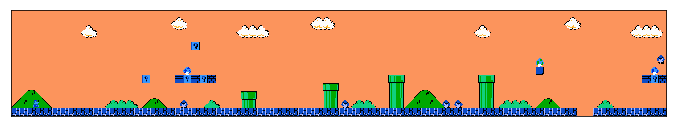

In [27]:

levelStr = [['-' for xx in range(maxX+1)] for yy in range(maxY+1)] 
for loc,tile in levelMap.items():
    levelStr[loc[1]][loc[0]] = tile
for line in levelStr:
    print ''.join([legend[l] for l in line][:80])
    
    
plt.figure(figsize=(11.75,11.75))
plt.imshow(level[:,:80*16,:])
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',   # labels along the bottom edge are off
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') # labels along the bottom edge are off) 
plt.show()



In [20]:
def get_tile_map(levelname,tile_path,have_priority,sprites):
    level = cv2.imread(levelname)
        
    levelMap = {}

    maxX = -1
    maxY = -1

    levelConf = {}
    levelPriority = {}
    priority = {sprite2ur[sprite]:0 for sprite in sprite2ur}
    for sprite in have_priority:
        priority[sprite] = 1
   


    #For all sprites
    for sprite in sprite2ur:
        #Find sprite locations and their associated confidences using OpenCV's template matching
        #as a default, only allow those with a confidence >= 0.7 to be considered
        locs,conf = findSubImageLocations(level,cv2.imread(join(tile_path, sprite)),0.7)

        for yy,xx,c in zip(locs[0],locs[1],conf):
            mx = xx/16.
            my = yy/16.

            xx = int(np.round(xx/16.))
            yy = int(np.round(yy/16.))
            #If something is more than 20% off center, only allow it if it is a sprite
            if (abs(xx-mx) > 0.2 or abs(yy-my) > 0.2) and sprite2ur[sprite] not in sprites:
                continue
            #Default to a confidence of -1
            if (xx,yy) not in levelConf:

                levelConf[(xx,yy)] = -1
                levelPriority[(xx,yy)] = -1
            #If the current image has higher confidence and priority
            if  c >levelConf[(xx,yy)] and priority[sprite2ur[sprite]] >= levelPriority[(xx,yy)]:
                levelPriority[(xx,yy)] = priority[sprite2ur[sprite]]
                levelConf[(xx,yy)] = c
                levelMap[(xx,yy)] = sprite2ur[sprite]
            #Keep track of level sizes
            maxX = max(maxX,xx)
            maxY = max(maxY,yy)
            
    levelStr = [['-' for xx in range(maxX+1)] for yy in range(maxY+1)] 
    for loc,tile in levelMap.items():
        levelStr[loc[1]][loc[0]] = tile
    outStr = '\n'.join([''.join([legend[l] for l in line]) for line in levelStr])
    return outStr


In [28]:

have_priority = ['question_mushroom','question_star','coinblock','question_1up']
sprites = set(['red_koopa','flying_koopa','Koopa','Goomba','hammerbro','flying_red_koopa',
               'Pirannha','Girder','buzzy_beetle','spiny','mushroom_bridge'])

output_prefix = 'smb_level'
tile_path = 'SMBTiles'
level_path = 'VGLC/Super Mario Bros/Original/'

for file_index, filename in enumerate([join(level_path,f) for f in listdir(level_path) if isfile(join(level_path, f))]):
    with open(output_prefix + '{}.txt'.format(file_index),'w') as output_file:
        output_file.write(get_tile_map(filename,tile_path = tile_path,
                                       have_priority=have_priority, sprites=sprites).encode('utf8'))

KeyboardInterrupt: 